In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
delta = 2
beta = 1
num_paths = 10000
num_steps = 100

# 1. Pour un call européen standard, tracer l’écart entre le prix CEV (explicite et par Monte Carlo) et le prix Black & Scholes en fonction de S0 dans le cas $\beta = 1$. On choisira $\delta$ de sorte que le prix à la monnaie soit égal au prix Black & Scholes.

In [3]:
def call_cev_price_explicit(S, K, T, r, delta, beta):
    k = (2 * r) / ((delta ** 2) * (2 - beta) * (np.exp(r * (2 - beta) * (T)) - 1))
    x = k * (S0 ** (2 - beta)) * np.exp(r * (2 - beta) * T)
    y = k * K ** (2 - beta)
    Q = lambda x, a, b: stats.ncx2.sf(x=x, df=a, nc=b)
    price = S * Q(2 * y, 2 + 2 / (2 - beta), 2 * x) - K * np.exp(-r * T) * (1 - Q(2 * x, 2 / (2 - beta), 2 * y))
    return max(price, 0)

def cev_price(S0, K, T, r, delta, beta, num_paths, num_steps):
    dt = T / num_steps
    payoffs = np.zeros(num_paths)

    for i in range(num_paths):
        S = S0
        for j in range(num_steps):
            dB = np.sqrt(dt) * np.random.randn()
            S += r * max(S,0) * dt + delta * max(S, 0)**(beta/2) * dB
        payoffs[i] = max(S - K, 0)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

def black_scholes_call(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * stats.norm.cdf(d1) - X * np.exp(-r * T) * stats.norm.cdf(d2)

    return call_price

call_price_cev_explicit = call_cev_price_explicit(S0, K, T, r, delta, beta)
call_price_cev = cev_price(S0, K, T, r, delta, beta, num_paths, num_steps)
call_price_bs = black_scholes_call(S0, K, T, r, sigma)
print(f" Prix du call CEV explicite : {call_price_cev_explicit}")
print(f" Prix du call CEV : {call_price_cev}")
print(f" Prix du call Black-Scholes : {call_price_bs}")
print("\n Paramètres :")
print(f" Sigma Black-Scholes : {sigma}")
print(f" Delta CEV : {delta}")

 Prix du call CEV explicite : 10.453885328717924
 Prix du call CEV : 10.61733771040643
 Prix du call Black-Scholes : 10.450583572185565

 Paramètres :
 Sigma Black-Scholes : 0.2
 Delta CEV : 2


In [4]:
S = np.linspace(0, 2*K, 30)
prices_cev_explicit = np.zeros(len(S))
prices_cev = np.zeros(len(S))
prices_bs = np.zeros(len(S))

for i, s in enumerate(S):
  prices_cev_explicit[i] = call_cev_price_explicit(s, K, T, r, delta, beta)
  prices_cev[i] = cev_price(s, K, T, r, delta, beta, num_paths, num_steps)
  prices_bs[i] = black_scholes_call(s, K, T, r, sigma)

diff_cev_explicit = prices_cev_explicit - prices_bs
diff_cev = prices_cev - prices_bs

<ipython-input-3-f0a24f52e931>:24: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


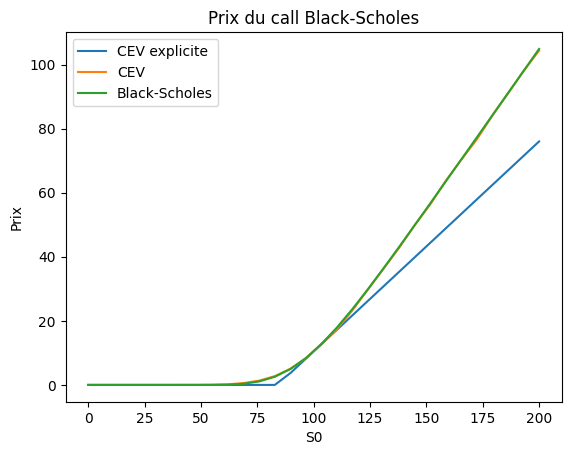

In [5]:
plt.plot(S, prices_cev_explicit, label="CEV explicite")
plt.plot(S, prices_cev, label="CEV")
plt.plot(S, prices_bs, label="Black-Scholes")
plt.title("Prix du call Black-Scholes")
plt.xlabel("S0")
plt.ylabel("Prix")
plt.legend()

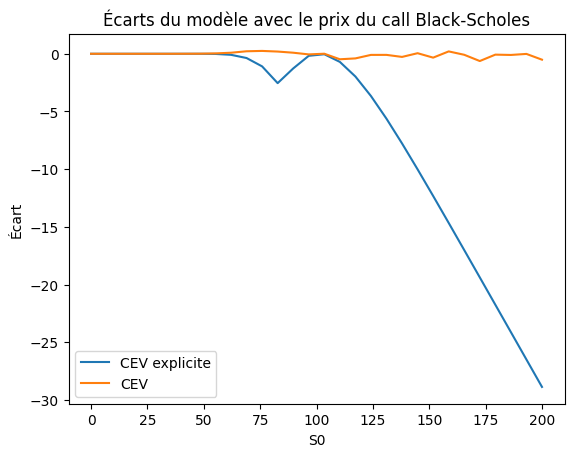

In [6]:
plt.plot(S, diff_cev_explicit, label="CEV explicite")
plt.plot(S, diff_cev, label="CEV")
plt.title("Écarts du modèle avec le prix du call Black-Scholes")
plt.xlabel("S0")
plt.ylabel("Écart")
plt.legend()

Nous remarquons que les prix BS et CEV sont très proches lorsque l'on chosiit une valeur de $\delta$ de sorte que le prix à la monnaie soit égale au prix BS.
Néanmoins, pour les prix CEV explicites, il semblerait que les hypothèses faites par Mark Schroder permettent une bonne approximation pour un S0 très proche du strike. Pour des valeurs de S0 très supérieurs au strike, le prix explicite n'a aucun sens. De plus, il semble manquer de "convexité" dans la courbe du prix du call CEV explicite en fonction de S0.

# 2. Etudier la déformation du smile/skew de volatilité du modèle CEV en fonction de $\beta$ (toujours en choisissant $\delta$ de sorte que le prix à la monnaie soit égal au prix Black & Scholes).

In [7]:
def func(delta):
  return call_cev_price_explicit(S0, K, T, r, delta, beta) - black_scholes_call(S0, K, T, r, sigma)

def find_delta_dichotomy(a, b, tol=1e-4, max_iter=100):
    if func(a) * func(b) > 0:
      return None

    iteration = 0
    while (b - a) / 2 > tol and iteration < max_iter:
        midpoint = (a + b) / 2
        if func(midpoint) == 0:
            return midpoint
        elif func(midpoint) * func(a) < 0:
            b = midpoint
        else:
            a = midpoint
        iteration += 1

    root = (a + b) / 2
    return root

find_delta_dichotomy(0, 100)

<ipython-input-3-f0a24f52e931>:2: RuntimeWarning: divide by zero encountered in double_scalars
  k = (2 * r) / ((delta ** 2) * (2 - beta) * (np.exp(r * (2 - beta) * (T)) - 1))


1.9991874694824219

In [8]:
def implied_volatility(option_price, S, K, T, r, tol=1e-5, max_iter=1000):
    lower_volatility = 0.
    upper_volatility = 2.0

    iteration = 0
    while iteration < max_iter:
        mid_volatility = (lower_volatility + upper_volatility) / 2
        option_price_mid = black_scholes_call(S, K, T, r, mid_volatility)
        if np.abs(option_price_mid - option_price) < tol:
            return mid_volatility

        if option_price_mid < option_price:
            lower_volatility = mid_volatility
        else:
            upper_volatility = mid_volatility

        iteration += 1
    return mid_volatility

In [9]:
strikes = np.arange(50, 151, 5)
threshold = 1e-10

prices_cev = np.zeros(len(strikes))
implied_vols = np.zeros(len(strikes))

for i, strike in enumerate(strikes):
  prices_cev[i] = cev_price(S0, strike, T, r, delta, beta, num_paths, num_steps)
  implied_vols[i] = implied_volatility(prices_cev[i], S0, strike, T, r)
implied_vols = np.where(implied_vols>threshold, implied_vols, np.nan)

<ipython-input-3-f0a24f52e931>:2: RuntimeWarning: divide by zero encountered in double_scalars
  k = (2 * r) / ((delta ** 2) * (2 - beta) * (np.exp(r * (2 - beta) * (T)) - 1))


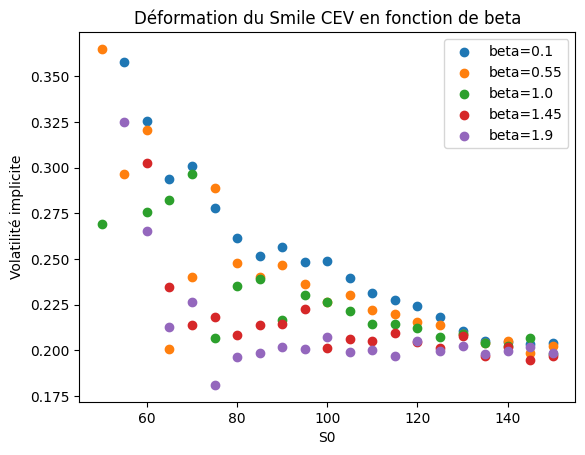

In [10]:
beta_values = np.linspace(0.1, 1.9, 5)

for beta_ in beta_values:
  vol_values = np.zeros(len(strikes))
  K = strike
  beta = beta_
  delta_ = find_delta_dichotomy(0, 100)
  for i, strike in enumerate(strikes):
    prices_cev[i] = cev_price(S0, strike, T, r, delta_, beta_ , num_paths, num_steps)
    vol_values[i] = implied_volatility(prices_cev[i], S0, strike, T, r)
  vol_values = np.where(vol_values>threshold, vol_values, np.nan)
  plt.scatter(strikes, vol_values, label=f"beta={np.round(beta_,2)}")
plt.title("Déformation du Smile CEV en fonction de beta")
plt.xlabel("S0")
plt.ylabel("Volatilité implicite")
plt.legend()

Les graphiques ont été tracés de manière discontinue à cause d'instabilités numériques. Nous remarquons néanmoins qu'une valeur de $\beta$ proche de 2 semble applatir le smile CEV. C'est normal car si nous choisissons un $\beta = 2$ nous nous retrouvons dans un modèle de Black-Scholes classique dont le smile est plat. Plus la valeur de $\beta$ est proche de 0, plus le convexité du skew est importante.

# 3. Question ouverte : que dire du cas $\beta$ > 2 ?

Si le $\beta$ est supérieur à 2, cela signifie que la volatilité augmente plus rapidement que linéairement avec le prix de l'actif sous-jacent.

Si $\beta > 2$ , le processus de volatilité dans le modèle CEV devient très sensible aux changements de prix de l'actif sous-jacent. Cela peut conduire à des mouvements de prix plus extrêmes et à une volatilité accrue à des niveaux de prix très élevés.